In [77]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from __future__ import print_function
# import argparse
# import imghdr

Make Dataframe

In [78]:
PATH = "../data/unpacked/characters"

characters = os.listdir(PATH)

data = pd.DataFrame(columns=["Character", "Image", "Path"])

for i, character in enumerate(characters):
    path = os.path.join(PATH, character)

    for d in sorted(os.listdir(path)):
        img = cv2.imread(os.path.join(path, d))
        data = data.append({"Character": character, "Image": img, 'Path': os.path.join(path, d)}, ignore_index=True)



Store the data

In [79]:
%store data

Stored 'data' (DataFrame)


In [80]:
data.head()

,Character,Image,Path
0,Zayin,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",../data/unpacked/characters/Zayin/navis-QIrug-...
1,Zayin,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",../data/unpacked/characters/Zayin/navis-QIrug-...
2,Zayin,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",../data/unpacked/characters/Zayin/navis-QIrug-...
3,Zayin,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",../data/unpacked/characters/Zayin/navis-QIrug-...
4,Zayin,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",../data/unpacked/characters/Zayin/navis-QIrug-...


In [81]:
data["Character"].value_counts()

Tet             300
Taw             300
Tsadi-medial    300
Samekh          300
Het             300
Shin            300
Mem-medial      300
Alef            300
Gimel           300
Bet             300
He              300
Nun-medial      300
Ayin            300
Mem             300
Lamed           294
Qof             265
Kaf             193
Nun-final       130
Waw             116
Dalet            91
Resh             78
Tsadi-final      73
Pe               37
Yod              23
Pe-final         15
Zayin            12
Kaf-final        10
Name: Character, dtype: int64

Hash function

In [82]:
def dhash(image, hashSize=8):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))
	
	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]
	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


Hash images and find duplicates

In [83]:
hashes = {}
for imgPath in data['Path']:
    img = cv2.imread(imgPath)
    hash = dhash(img)
    
    # if the current hash already exists in our dictionary, add the path
    p = hashes.get(hash, [])
    p.append(imgPath)
    hashes[hash] = p


Delete the duplicates

In [84]:
for (h, hashedPaths) in hashes.items():
   
    # if hash has multiple paths, it's a duplicate
    if len(hashedPaths) > 1:        

        # delete images only keep the first image
        for imgPath in hashedPaths[1:]:

            # os.remove(imgPath)
            data.drop(data[data['Path'] == imgPath].index, inplace=True)
            print("removed: {}".format(imgPath))
        

removed: ../data/unpacked/characters/Alef/navis-QIrug-Qumran_extr09_0057-line-029-y1=1356-y2=1476-zone-HUMAN-x=1398-y=0027-w=0038-h=0037-ybas=0042-nink=718-segm=COCOS5cocos.pgm
removed: ../data/unpacked/characters/Mem/navis-QIrug-Qumran_extr09_1295-line-012-y1=1617-y2=1799-zone-HUMAN-x=2428-y=0058-w=0048-h=0069-ybas=0089-nink=1349-segm=COCOS5cocos.pgm
removed: ../data/unpacked/characters/Shin/navis-QIrug-Qumran_extr09_2400-line-014-y1=719-y2=832-zone-HUMAN-x=2120-y=0021-w=0044-h=0039-ybas=0028-nink=585-segm=COCOS5cocos.pgm
removed: ../data/unpacked/characters/Kaf/navis-QIrug-Qumran_extr09_0374-line-029-y1=1104-y2=1217-zone-HUMAN-x=1545-y=0021-w=0036-h=0048-ybas=0024-nink=682-segm=COCOS5cocos.pgm
removed: ../data/unpacked/characters/Nun-medial/navis-QIrug-Qumran_extr09_2194-line-024-y1=1519-y2=1642-zone-HUMAN-x=0331-y=0025-w=0030-h=0040-ybas=0042-nink=369-segm=COCOS5cocos.pgm
removed: ../data/unpacked/characters/Gimel/navis-QIrug-Qumran_extr09_1645-line-015-y1=1277-y2=1411-zone-HUMAN-x=

In [85]:
data["Character"].value_counts()

Tsadi-medial    294
Lamed           290
Samekh          285
He              285
Mem             285
Mem-medial      284
Bet             284
Nun-medial      284
Alef            281
Taw             279
Ayin            279
Gimel           278
Tet             277
Het             275
Shin            273
Qof             260
Kaf             180
Nun-final       130
Waw             101
Dalet            84
Resh             73
Tsadi-final      71
Pe               37
Yod              21
Pe-final         14
Zayin            12
Kaf-final         9
Name: Character, dtype: int64

Split train test data

In [103]:
x_train, x_test, y_train, y_test = train_test_split(data['Path'], data["Character"], test_size=.2, random_state=313, stratify=data["Character"])

Augment the data

In [102]:
src = None
erosion_size = 1
dilation_size = 1
max_elem = 2


In [111]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

save_path = ("../data/unpacked/AugmentedData")
DataDIR = ("../data/unpacked/characters")

if os.path.exists(save_path) == False:
        os.mkdir(save_path)



In [106]:
classes = y_train.unique()
classes

array(['Het', 'Alef', 'Shin', 'Resh', 'Samekh', 'Taw', 'Gimel', 'Lamed',
       'Zayin', 'Bet', 'Ayin', 'Tet', 'He', 'Kaf', 'Nun-medial',
       'Tsadi-medial', 'Mem-medial', 'Mem', 'Dalet', 'Nun-final', 'Waw',
       'Qof', 'Pe', 'Tsadi-final', 'Kaf-final', 'Yod', 'Pe-final'],
      dtype=object)

In [112]:
classes = data['Character'].unique()

for k in range(len(classes)):

    if os.path.exists(os.path.join(save_path, classes[k]) == False):
        os.mkdir(os.path.join(save_path, classes[k]))
    
    # for j in range(len(data['Path'])):

    #     img = load_img(data['Image'][j])
    
# for k in range?(len(data['Character'].unique)):


In [ ]:
sub_dir = os.listdir(DataDIR)
for k in range(len(sub_dir)):
    
    images_loc = os.listdir(DataDIR + '/' + sub_dir[k])
    if os.path.exists(save_path + '/' + sub_dir[k]) == False:
        os.mkdir(save_path + '/' + sub_dir[k])

    for j in range(len(images_loc)):

        img = load_img(DataDIR + '/' + sub_dir[k] +'/' + images_loc[j])  # this is a PIL image
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `AugementedData/` directory
        i = 0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=save_path+"/"+sub_dir[k], save_prefix=sub_dir[k],):
            i += 1
            if i > 20:
                break
    print(sub_dir[k], 'is over...')

In [ ]:
# loop over data and augment each image
for imgPath in data['Path']:
    if os.path.exists(save_path + '/' +     data['Character']) == False:
        os.mkdir(save_path + '/' + data['Character'])

    img = load_img(imgPath)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix="Augmented"):
        i += 1
        if i > 20:
            break
    print(imgPath, 'is over...')


In [52]:
# erode the image
def erosion(image: np.ndarray, kernel_size: int, iterations: int)-> np.ndarray:
    
    elements = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * erosion_size + 1, 2 * erosion_size + 1), (erosion_size, erosion_size))
    
    return cv2.erode(image, elements, iterations=iterations)

# dilate the image
def dilation(image: np.ndarray, kernel_size: int, iterations: int)-> np.ndarray:
    
    elements = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * dilation_size + 1, 2 * dilation_size + 1), (dilation_size, dilation_size))
    
    return cv2.dilate(image, elements, iterations=iterations)

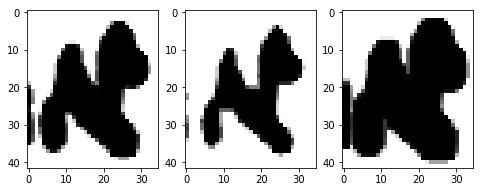

In [53]:
PATH = "../data/unpacked/characters/Alef/navis-QIrug-Qumran_extr09_0001-line-008-y1=400-y2=515-zone-HUMAN-x=1650-y=0049-w=0035-h=0042-ybas=0027-nink=631-segm=COCOS5cocos.pgm"
if PATH is None:
    print('Could not open or find the image: ', PATH)
    exit(0)
img = cv2.imread(PATH)
fig = plt.figure(figsize=(8, 8))

# erosion
erose = erosion(img, erosion_size,1)
# dialate the image
dilate = dilation(img, erosion_size,1)
fig.add_subplot(2,3,1)
plt.imshow(img)
fig.add_subplot(2,3,2)
plt.imshow(dilate)
fig.add_subplot(2,3,3)
plt.imshow(erose)

plt.show()
